In [56]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import dill
import joblib

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, cohen_kappa_score, r2_score
from sentence_transformers import SentenceTransformer

c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import optuna
import language_tool_python

In [5]:
from textstat import flesch_kincaid_grade
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import RobertaTokenizer, RobertaModel

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [8]:
nltk.data.path.append(os.path.abspath('nltk_data'))

In [9]:

nltk.download('punkt_tab', download_dir='nltk_data')
nltk.download('omw-1.4', download_dir='nltk_data')
nltk.download('stopwords' , download_dir='nltk_data')
nltk.download('wordnet' , download_dir='nltk_data')
nltk.download('averaged_perceptron_tagger_eng' , download_dir='nltk_data')

[nltk_data] Downloading package punkt_tab to nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

---


In [10]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', encoding='latin1')
    df = df[['essay_id', 'essay_set', 'essay', 'domain1_score']].dropna()
    return df

In [11]:
essays = load_data('../Dataset/asap-aes/training_set_rel3.tsv')

- essay_id: A unique identifier for each individual student essay
- essay_set: 1-8, an id for each set of essays
- essay: The ascii text of a student's response
- rater1_domain1: Rater 1's domain 1 score; all essays have this
- rater2_domain1: Rater 2's domain 1 score; all essays have this
- rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this.
- domain1_score: Resolved score between the raters; all essays have this
- rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this
- rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this
- domain2_score: Resolved score between the raters; only essays in set 2 have this
- rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8


In [12]:
essays

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40


In [13]:
essays.describe()

,essay_id,essay_set,domain1_score
count,12976.000000,12976.000000,12976.000000
mean,10295.395808,4.179485,6.800247
std,6309.074105,2.136913,8.970705
min,1.000000,1.000000,0.000000
25%,4438.750000,2.000000,2.000000
50%,10044.500000,4.000000,3.000000
75%,15681.250000,6.000000,8.000000
max,21633.000000,8.000000,60.000000


In [14]:
essays['domain1_score'].unique()

array([ 8,  9,  7, 10,  6, 12,  4,  3, 11,  2,  5,  1,  0, 15, 13, 17, 23,
       16, 18, 19, 14, 21, 24, 20, 22, 34, 46, 40, 30, 26, 41, 31, 44, 36,
       43, 45, 35, 42, 33, 38, 47, 32, 50, 39, 37, 55, 60, 28, 49, 29, 27,
       25, 48], dtype=int64)

---


# Preprocess


In [15]:
class EssayPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english') )
        self.lemmatizer = WordNetLemmatizer()
        self.grammar_tool = language_tool_python.LanguageTool('en-US')
        self.sbert = SentenceTransformer('all-mpnet-base-v2', device="cuda")
        
    def preprocess_text(self, text):
        # Basic
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        # Tokenization and stopword removal
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words]
        
        # Lemmi
        pos_tags = nltk.pos_tag(tokens)
        lemmatized = []
        for word, tag in pos_tags:
            if tag.startswith('V'):  # Verb
                lemmatized.append(self.lemmatizer.lemmatize(word, 'v'))
            elif tag.startswith('J'):  # Adjective
                lemmatized.append(self.lemmatizer.lemmatize(word, 'a'))
            elif tag.startswith('R'):  # Adverb
                lemmatized.append(self.lemmatizer.lemmatize(word, 'r'))
            else:  # Noun
                lemmatized.append(self.lemmatizer.lemmatize(word))
                
        return ' '.join(lemmatized)
    
    def extract_linguistic_features(self, text):
         # Grammar and spelling
        matches = self.grammar_tool.check(text)
        grammar_errors = len(matches)
        
        # Readability
        readability = flesch_kincaid_grade(text)
        
        
        # Vocabulary richness
        words = word_tokenize(text)
        unique_words = set(words)
        vocab_richness = len(unique_words) / max(1, len(words))
        
        # Essay structure
        sentences = nltk.sent_tokenize(text)
        avg_sentence_len = sum(len(word_tokenize(s)) for s in sentences) / max(1, len(sentences))
        
        return {
            'grammar_errors': grammar_errors,
            'readability': readability,
            'vocab_richness': vocab_richness,
            'avg_sentence_len': avg_sentence_len
        }
    
    def get_sbert_embedding(self, text):
        return self.sbert.encode(text, show_progress_bar=False)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        del state['grammar_tool']
        del state['sbert']
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)
        self.grammar_tool = language_tool_python.LanguageTool('en-US')
        self.sbert = SentenceTransformer('all-mpnet-base-v2')

In [16]:
preprocessor = EssayPreprocessor()

In [17]:
essays['processed_text'] = essays['essay'].apply(preprocessor.preprocess_text)



In [18]:
essays

,essay_id,essay_set,essay,domain1_score,processed_text
0,1,1,"Dear local newspaper, I think effects computer...",8,dear local newspaper think effect computer peo...
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,dear cap cap believe use computer benefit u ma...
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,dear cap cap cap people use computer everyone ...
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,dear local newspaper cap find many expert say ...
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,dear location know computer positive effect pe...
...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35,story mother daughter either enemy friends cap...
12972,21628,8,I never understood the meaning laughter is th...,32,never understood meaning laughter short distan...
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40,laugh cap habit cap cause cause laugh cap even...
12974,21630,8,Trippin' on fen...,40,trippin fence num year young short num year ev...


In [19]:
linguistic_features = essays['processed_text'].apply(preprocessor.extract_linguistic_features)
linguistic_df =  pd.json_normalize(linguistic_features)

In [20]:
linguistic_df

,grammar_errors,readability,vocab_richness,avg_sentence_len
0,24,66.9,0.650307,163.0
1,29,92.6,0.535398,226.0
2,8,59.9,0.589928,139.0
3,34,123.8,0.526667,300.0
4,24,93.4,0.546667,225.0
...,...,...,...,...
12971,30,169.8,0.509302,430.0
12972,26,107.8,0.469314,277.0
12973,27,159.7,0.613466,401.0
12974,18,105.9,0.589354,263.0


In [21]:
print("Generating SBERT embeddings...")
sbert_embeddings = np.array(essays['processed_text'].apply(preprocessor.get_sbert_embedding).tolist())
sbert_df = pd.DataFrame(sbert_embeddings)

Generating SBERT embeddings...


In [22]:
sbert_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.031583,0.033282,-0.015308,-0.013306,0.000161,-0.010747,0.038203,0.001588,0.044676,-0.013628,...,0.025675,0.023589,-0.020465,0.010807,0.018727,0.079253,0.001707,0.046076,0.003998,-0.008758
1,0.005879,0.089399,-0.015278,-0.000925,0.017863,0.002223,0.056568,-0.005401,0.051621,-0.028052,...,0.042643,0.028052,-0.015593,0.040660,0.019566,0.046135,-0.022946,0.015616,-0.017776,-0.021477
2,0.022280,0.070561,-0.016688,-0.011760,0.000120,-0.008693,0.028661,-0.005685,0.068110,-0.006680,...,0.035543,-0.001292,0.000365,0.038471,0.024054,0.018203,-0.030336,-0.006662,0.005332,-0.015472
3,0.004262,0.079211,-0.009750,-0.036469,0.005397,-0.008175,0.049303,0.012156,0.041357,-0.030519,...,0.044019,0.015879,-0.009117,0.028251,0.015467,0.014117,-0.041931,-0.035711,-0.031452,-0.021299
4,0.005242,0.075865,-0.029652,-0.016358,-0.010246,-0.005757,0.059698,0.003445,0.036962,-0.034731,...,0.030697,0.036115,-0.029009,0.038143,0.000350,-0.008665,-0.023774,0.015103,0.013976,-0.025849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,0.025516,0.028223,-0.022013,0.041223,-0.001615,0.014507,0.021554,0.004433,-0.002967,-0.026275,...,0.019130,0.027143,-0.063738,0.030238,-0.009724,-0.000353,0.017741,0.004954,0.020734,-0.011070
12972,0.050011,0.000181,-0.012728,0.007693,-0.008114,0.031831,0.035020,0.029745,0.045216,-0.018161,...,-0.017537,0.004798,-0.020590,0.030431,-0.022930,-0.004030,-0.013001,0.035315,0.039497,-0.029806
12973,0.020686,0.024948,-0.003596,0.022467,0.009656,0.012359,-0.023859,0.062546,0.074937,-0.031453,...,0.044309,0.018240,-0.044093,0.035990,-0.032573,0.024159,0.027775,0.023735,0.026880,-0.016355
12974,0.018955,0.050837,0.010363,0.017801,0.002610,0.012250,-0.014248,0.041565,0.053339,-0.024261,...,0.009664,0.015488,-0.052494,0.007944,-0.014139,0.034119,0.002569,0.022877,0.059482,-0.028157


In [23]:
X = pd.concat([linguistic_df, sbert_df], axis=1)
y = essays['domain1_score']

In [24]:
X

,grammar_errors,readability,vocab_richness,avg_sentence_len,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,24,66.9,0.650307,163.0,0.031583,0.033282,-0.015308,-0.013306,0.000161,-0.010747,...,0.025675,0.023589,-0.020465,0.010807,0.018727,0.079253,0.001707,0.046076,0.003998,-0.008758
1,29,92.6,0.535398,226.0,0.005879,0.089399,-0.015278,-0.000925,0.017863,0.002223,...,0.042643,0.028052,-0.015593,0.040660,0.019566,0.046135,-0.022946,0.015616,-0.017776,-0.021477
2,8,59.9,0.589928,139.0,0.022280,0.070561,-0.016688,-0.011760,0.000120,-0.008693,...,0.035543,-0.001292,0.000365,0.038471,0.024054,0.018203,-0.030336,-0.006662,0.005332,-0.015472
3,34,123.8,0.526667,300.0,0.004262,0.079211,-0.009750,-0.036469,0.005397,-0.008175,...,0.044019,0.015879,-0.009117,0.028251,0.015467,0.014117,-0.041931,-0.035711,-0.031452,-0.021299
4,24,93.4,0.546667,225.0,0.005242,0.075865,-0.029652,-0.016358,-0.010246,-0.005757,...,0.030697,0.036115,-0.029009,0.038143,0.000350,-0.008665,-0.023774,0.015103,0.013976,-0.025849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,30,169.8,0.509302,430.0,0.025516,0.028223,-0.022013,0.041223,-0.001615,0.014507,...,0.019130,0.027143,-0.063738,0.030238,-0.009724,-0.000353,0.017741,0.004954,0.020734,-0.011070
12972,26,107.8,0.469314,277.0,0.050011,0.000181,-0.012728,0.007693,-0.008114,0.031831,...,-0.017537,0.004798,-0.020590,0.030431,-0.022930,-0.004030,-0.013001,0.035315,0.039497,-0.029806
12973,27,159.7,0.613466,401.0,0.020686,0.024948,-0.003596,0.022467,0.009656,0.012359,...,0.044309,0.018240,-0.044093,0.035990,-0.032573,0.024159,0.027775,0.023735,0.026880,-0.016355
12974,18,105.9,0.589354,263.0,0.018955,0.050837,0.010363,0.017801,0.002610,0.012250,...,0.009664,0.015488,-0.052494,0.007944,-0.014139,0.034119,0.002569,0.022877,0.059482,-0.028157


In [25]:
y

0         8
1         9
2         7
3        10
4         8
         ..
12971    35
12972    32
12973    40
12974    40
12975    40
Name: domain1_score, Length: 12976, dtype: int64

---


In [26]:
class AESModel(nn.Module):
    def __init__(self, input_dim):
        super(AESModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc_out(x)

In [27]:
def train_model(X_train, y_train, params):

    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    model = AESModel(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    

    for epoch in range(params['epochs']):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    return model

In [28]:

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test.values)
        predictions = model(X_test_tensor).squeeze().numpy()

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    return {
        'predictions': predictions,
        'mse': mse,
        'rmse': rmse,
        'r2': r2  
    }

In [29]:
def objective(trial):
    
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'epochs': trial.suggest_int('epochs', 20, 100),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    }
    
    kf = KFold(n_splits=5)
    rmse_scores = []  
    r2_scores = []  
    

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
   
        model = train_model(X_train, y_train, params)
      
        metrics = evaluate_model(model, X_val, y_val)
        
  
        rmse_scores.append(metrics['rmse'])
        r2_scores.append(metrics['r2'])

    return np.mean(rmse_scores)


In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-04-26 17:15:18,896] A new study created in memory with name: no-name-c05507c7-b56f-4be3-8dc3-7c1ed4a4a8e0
[I 2025-04-26 17:18:44,934] Trial 0 finished with value: 6.067591045341178 and parameters: {'lr': 0.00011955738081119607, 'batch_size': 64, 'epochs': 56, 'weight_decay': 1.1947497687468665e-06}. Best is trial 0 with value: 6.067591045341178.
[I 2025-04-26 17:29:57,284] Trial 1 finished with value: 6.512791124029155 and parameters: {'lr': 0.0005685099894534698, 'batch_size': 16, 'epochs': 63, 'weight_decay': 0.0008251880740928776}. Best is trial 1 with value: 6.512791124029155.
[I 2025-04-26 17:33:50,313] Trial 2 finished with value: 5.749452436080301 and parameters: {'lr': 0.0001653316534309764, 'batch_size': 64, 'epochs': 60, 'weight_decay': 1.3211796542847741e-05}. Best is trial 1 with value: 6.512791124029155.
[I 2025-04-26 17:49:16,349] Trial 3 finished with value: 6.405109415976895 and parameters: {'lr': 0.0003022733335944427, 'batch_size': 16, 'epochs': 83, 'weight_de

Best hyperparameters: {'lr': 0.0005685099894534698, 'batch_size': 16, 'epochs': 63, 'weight_decay': 0.0008251880740928776}


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:

final_model = train_model(X_train, y_train, best_params)

results = evaluate_model(final_model, X_test, y_test)

In [33]:
print("\nFinal Evaluation Results:")
print(f"Mean Squared Error (MSE): {results['mse']:.4f}")
print(f"Root Mean Squared Error (RMSE): {results['rmse']:.4f}")
print(f"R-squared (R2): {results['r2']:.4f}")



Final Evaluation Results:
Mean Squared Error (MSE): 3.3850
Root Mean Squared Error (RMSE): 1.8398
R-squared (R2): 0.9565


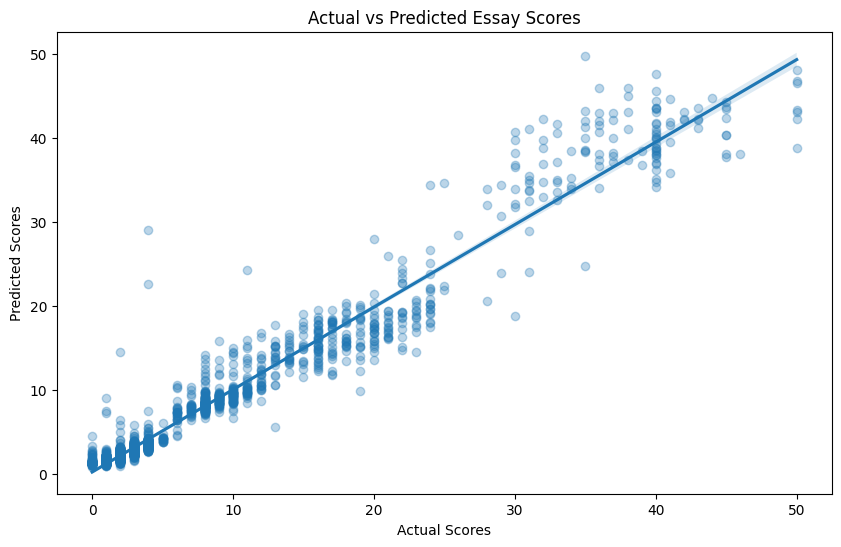

In [34]:

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=results['predictions'], scatter_kws={'alpha':0.3})
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Essay Scores')
plt.show()



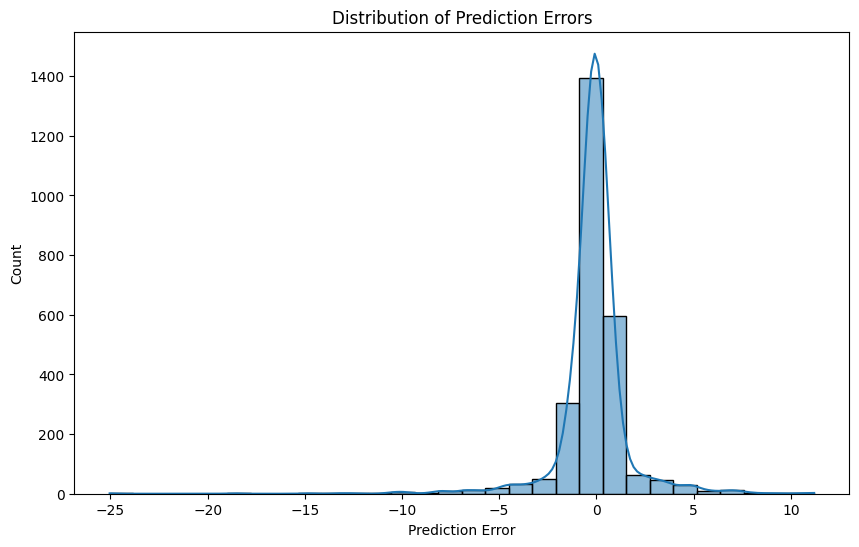

In [35]:
errors = y_test - results['predictions']
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.show()

---


Dump Model


In [52]:
MODEL_DIR = Path('./models')

In [57]:
with open(MODEL_DIR / "preprocessor.dill", "wb") as f:
    dill.dump(preprocessor, f)

with open(MODEL_DIR / "linguistic_features_columns.txt", "w") as f:
    f.write("\n".join(linguistic_df.columns))

with open(MODEL_DIR / "sbert_info.txt", "w") as f:
    f.write(f"embedding_dim:{sbert_df.shape[1]}")

torch.save({
    'model_state_dict': final_model.state_dict(),
    'input_dim': X_train.shape[1]
}, MODEL_DIR / "aes_model.pth")

model_metadata = {
    "best_params": best_params,
    "feature_columns": list(X.columns),
    "performance_metrics": results,
    "required_packages": {
        "language_tool_python": "3.7",  # Example version
        "sentence_transformers": "2.2.2",
        "torch": "1.12.1"
    }
}

joblib.dump(model_metadata, MODEL_DIR / "model_metadata.joblib")

print(f"All model components saved to {MODEL_DIR}")

All model components saved to models


---


In [63]:

essay_data = pd.read_excel('../Dataset/asap-aes/Essay_Set_Descriptions/Essay_Set_Descriptions/essay_set_descriptions.xlsx')

def preprocess_new_essay(essay, essay_set_id):
    processed_text = preprocessor.preprocess_text(essay)
    linguistic_features = preprocessor.extract_linguistic_features(processed_text)
    
    sbert_embedding = preprocessor.get_sbert_embedding(processed_text)
    
    linguistic_df = pd.json_normalize(linguistic_features)
    sbert_df = pd.DataFrame([sbert_embedding])
    
    X_new = pd.concat([linguistic_df, sbert_df], axis=1)
    
    essay_set_info = essay_data[essay_data['essay_set'] == essay_set_id]
    min_score = essay_set_info['min_domain1_score'].values[0]
    max_score = essay_set_info['max_domain1_score'].values[0]
    
    return X_new, min_score, max_score

def predict_essay_score(essay, model, essay_set_id):
    X_new, min_score, max_score = preprocess_new_essay(essay, essay_set_id)
    
    X_new_tensor = torch.FloatTensor(X_new.values)
    
    model.eval()
    with torch.no_grad():
        predicted_score = model(X_new_tensor).item() 
    
    normalized_predicted_score = (predicted_score - min_score) / (max_score - min_score)
    
    final_predicted_score = normalized_predicted_score * (max_score - min_score) + min_score
    
    return final_predicted_score

new_essay = """
Patience is a virtue that often goes unnoticed until it is truly tested. I remember a story about my grandmother, a woman whose patience was as vast as the ocean. She lived in a small village where life moved at a slower pace, and challenges were met with resilience and calm.
One summer, a severe drought struck the village. Crops withered, and water became scarce. While many villagers grew anxious and frustrated, my grandmother remained composed. She would wake up early every morning, walk miles to fetch water from a distant well, and return with a smile on her face. She never complained, even when the journey was exhausting.
Instead, she used the situation as an opportunity to teach us the value of perseverance and resourcefulness. She showed us how to conserve water, reuse it wisely, and support one another during tough times. Her patience inspired the entire village to come together, share resources, and find solutions.
In the end, the rains returned, and the village thrived once more. But the lesson my grandmother taught us about patience stayed with me forever. It reminded me that patience is not just about waiting; it is about enduring challenges with grace and finding strength in adversity.

"""

essay_set_id = 7


predicted_score = predict_essay_score(new_essay, final_model, essay_set_id)

print("Predicted Essay Score:", predicted_score)

Predicted Essay Score: 22.459840774536133


```markdown
# The Power of Patience

Patience is a virtue that often goes unnoticed until it is truly tested. I remember a story about my grandmother, a woman whose patience was as vast as the ocean. She lived in a small village where life moved at a slower pace, and challenges were met with resilience and calm.

One summer, a severe drought struck the village. Crops withered, and water became scarce. While many villagers grew anxious and frustrated, my grandmother remained composed. She would wake up early every morning, walk miles to fetch water from a distant well, and return with a smile on her face. She never complained, even when the journey was exhausting.

Instead, she used the situation as an opportunity to teach us the value of perseverance and resourcefulness. She showed us how to conserve water, reuse it wisely, and support one another during tough times. Her patience inspired the entire village to come together, share resources, and find solutions.

In the end, the rains returned, and the village thrived once more. But the lesson my grandmother taught us about patience stayed with me forever. It reminded me that patience is not just about waiting; it is about enduring challenges with grace and finding strength in adversity.
```

In [ ]:
def load_model_components(model_dir="models"):
    with open(Path(model_dir) / "preprocessor.dill", "rb") as f:
        preprocessor = dill.load(f)
    
    with open(Path(model_dir) / "linguistic_features_columns.txt", "r") as f:
        linguistic_columns = f.read().splitlines()
    
    with open(Path(model_dir) / "sbert_info.txt", "r") as f:
        sbert_dim = int(f.read().split(":")[1])
    
    model_info = torch.load(Path(model_dir) / "aes_model.pth")
    model = AESModel(input_dim=model_info['input_dim'])
    model.load_state_dict(model_info['model_state_dict'])
    
    metadata = joblib.load(Path(model_dir) / "model_metadata.joblib")
    
    return {
        'preprocessor': preprocessor,
        'linguistic_columns': linguistic_columns,
        'sbert_dim': sbert_dim,
        'model': model,
        'metadata': metadata
    }

# Usage:
components = load_model_components()
preprocessor = components['preprocessor']
model = components['model']